<a href="https://colab.research.google.com/github/LxYuan0420/eat_tensorflow2_in_30_days/blob/master/notebooks/3_1_Low_level_API_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The examples below use low-level APIs in Tensorflow to implement a linear regression model and a DNN binary classification model.

Low-level API includes tensor operation, graph and automatic differentiates

In [1]:
import tensorflow as tf

# Time Stamp
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)


1. Linear Rgression Model

(a) Data Preparation

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

#NUmber of samples
n = 400

# Generating the datasets
X = tf.random.uniform([n,2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
noise = tf.random.normal([n,1], mean=0.0, stddev=2.0)

Y = X@w0 + b0 + noise

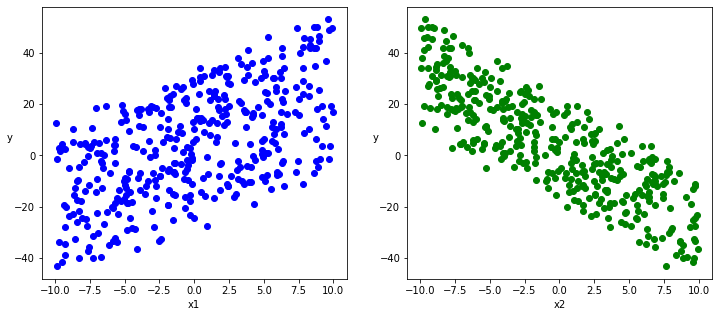

In [6]:
# Data Visualization

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0], Y[:, 0], c = "b")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1], Y[:, 0], c="g")
plt.xlabel("x2")
plt.ylabel("y", rotation=0)

plt.show()

In [8]:
# Creating generator of data pipeline
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = indices[i:min(i+batch_size, num_examples)]
        yield tf.gather(features, indexs), tf.gather(labels, indexs)
    
batch_size = 8
(features, labels) = next(data_iter(X,Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 2.1164417  -5.2859783 ]
 [ 2.1934938  -4.007616  ]
 [-9.30805    -5.5624485 ]
 [ 3.5495682   6.703369  ]
 [ 5.9925365   3.5878563 ]
 [-6.9850516  -0.87726593]
 [-3.6515093  -5.3628945 ]
 [-5.0281477   2.9639673 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 23.512161 ]
 [ 18.207237 ]
 [  2.3531213]
 [-11.026297 ]
 [  2.7017455]
 [ -9.083285 ]
 [ 10.942808 ]
 [-16.968264 ]], shape=(8, 1), dtype=float32)


**(b) Model Definition**

In [15]:
class LinearRegression:
    def __init__(self):
        self.w = tf.Variable(tf.random.normal([2,1]))
        self.b = tf.Variable(tf.zeros_like(b0, dtype=tf.float32))

    def __call__(self, x):
        return x@self.w + self.b

    def loss_function(self, y_true, y_pred):
        return tf.reduce_mean(((y_true-y_pred)**2)/2)


In [16]:
model = LinearRegression()

**(c) Model Training**

In [19]:
# Debug in dynamic graph
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_function(labels, predictions)
    
    dloss_dw, dloss_db = tape.gradient(loss, [model.w, model.b])
    model.w.assign(model.w-0.001*dloss_dw)
    model.b.assign(model.b-0.001*dloss_db)


    return loss

In [20]:
# Test the resutls of train step

batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=292.85635>

In [21]:
# repeat process and see if loss reduced

(features, labels) = next(data_iter(X,Y, batch_size))
train_step(model, features, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=284.93402>

In [24]:
def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        for features, labels in data_iter(X,Y, 10):
            loss = train_step(model, features, labels)

        if epoch%50 == 0:
            printbar()
            tf.print(f"epochs = {epoch} loss = {loss}")
            tf.print(f"w = {model.w}")
            tf.print(f"b = {model.b}")
    

In [25]:
train_model(model, epochs=200)

================================================================================17:07:40
epochs = 50 loss = 2.138854742050171
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9971797],
       [-2.9726682]], dtype=float32)>
w = <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[2.947176]], dtype=float32)>
================================================================================17:07:43
epochs = 100 loss = 1.0018720626831055
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.0072799],
       [-2.9796875]], dtype=float32)>
w = <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[2.9944196]], dtype=float32)>
================================================================================17:07:47
epochs = 150 loss = 2.165526866912842
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9995826],
       [-2.976483 ]], dtype=float32)>
w = <tf.Variable 'Variable:0' shape=(1, 1) dty

In [26]:
# Accelerate using Autograph to transform the dynamic graph into static 


@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_function(labels, predictions)
    
    dloss_dw, dloss_db = tape.gradient(loss, [model.w, model.b])
    model.w.assign(model.w-0.001*dloss_dw)
    model.b.assign(model.b-0.001*dloss_db)

    return loss

def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        for features, labels in data_iter(X,Y, 10):
            loss = train_step(model, features, labels)

            if epoch%50 == 0:
                printbar()
                tf.print(f"epochs = {epoch} loss = {loss}")
                tf.print(f"w = {model.w}")
                tf.print(f"b = {model.b}")
        


In [27]:
train_model(model, epochs=200)

================================================================================17:20:50
epochs = 50 loss = 1.4395374059677124
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9932986],
       [-2.963824 ]], dtype=float32)>
b = <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[3.001758]], dtype=float32)>
================================================================================17:20:50
epochs = 50 loss = 0.9505121111869812
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.994792 ],
       [-2.9623084]], dtype=float32)>
b = <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[3.0007517]], dtype=float32)>
================================================================================17:20:50
epochs = 50 loss = 2.1096651554107666
w = <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9940667],
       [-2.9622898]], dtype=float32)>
b = <tf.Variable 'Variable:0' shape=(1, 1) dty

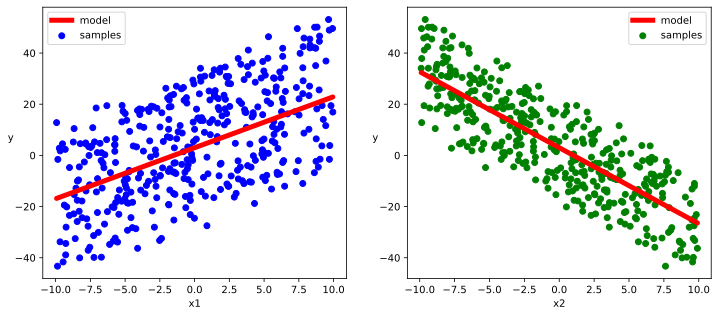

In [31]:
# Visualizing the results

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],model.w[0]*X[:,0]+model.b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],model.w[1]*X[:,1]+model.b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

---
2. DNN Binary Classification Model

**(a) Data Prepraration**

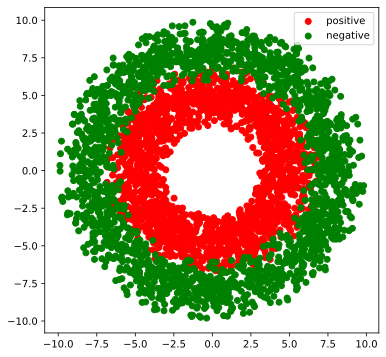

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'


n_positive, n_negative = 2000, 2000


# Generating the positive samples with a distribution on a smaller ring
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

# Generating the negative samples with a distribution on a larger ring
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

# Assembling all samples
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


# Visualizing the data
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


In [33]:
# Create the generator of the data pipeline
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  # Randomizing the reading order of the samples
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# Testing data pipeline
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 1.0455521   5.647144  ]
 [ 6.9311943  -3.9375553 ]
 [ 7.6832733  -2.2332497 ]
 [ 5.312224    4.4453106 ]
 [ 0.78794974 -4.710547  ]
 [ 4.193302   -7.173141  ]
 [ 6.594011   -2.0254092 ]
 [-1.2911257  -8.470748  ]
 [-7.505268    4.4231033 ]
 [ 4.40433     1.3285024 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]], shape=(10, 1), dtype=float32)


**(b) Model Definition**

Here the `tf.Module` is used for organizing the parameters in the model. You may refer to the last section of Chapter 4 for more details of `tf.Module`.

In [50]:
class DNNModel(tf.Module):
    def __init__(self):
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]), dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]), dtype=tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]), dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]), dtype=tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]), dtype=tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]), dtype=tf.float32)

    #forward propagation 
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def __call__(self, x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
    
        return y

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                                   tf.TensorSpec(shape=[None,1], dtype=tf.float32)])
    def loss_func(self, y_true, y_pred):
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return tf.reduce_mean(bce)

    @tf.function(input_signature=[
                    tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                    tf.TensorSpec(shape=[None, 1], dtype=tf.float32)])
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred >0.5, tf.ones_like(y_pred, dtype=tf.float32),
                          tf.zeros_like(y_pred, dtype=tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc

                    

In [51]:
model = DNNModel()

In [52]:
# Testing the struccture of model
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)
loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

tf.print(f"init loss: {loss}")
tf.print(f"init metric: {metric}")

init loss: 3.344489336013794
init metric: 0.699999988079071


In [53]:
print(len(model.trainable_variables))

6


**(c) Model Training**

In [54]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
        
    grads = tape.gradient(loss, model.trainable_variables)

    for p, dloss_dp in zip(model.trainable_variables, grads):
        p.assign(p-0.001*dloss_dp)
    
    metrics = model.metric_func(labels, predictions)

    return loss, metrics
    
def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        for features, labels in data_iter(X, Y, 100):
            loss, metrics = train_step(model, features, labels)

        if epoch%100 == 0:
            printbar()
            tf.print(f"epochs = {epoch} loss = {loss.numpy()} metrics: {metrics.numpy()}")





In [55]:
train_model(model, 600)

================================================================================18:32:33
epochs = 100 loss = 0.649665355682373 metrics: 0.6100000143051147
================================================================================18:32:38
epochs = 200 loss = 0.5895582437515259 metrics: 0.6899999976158142
================================================================================18:32:42
epochs = 300 loss = 0.5093223452568054 metrics: 0.7300000190734863
================================================================================18:32:46
epochs = 400 loss = 0.5232006907463074 metrics: 0.7099999785423279
================================================================================18:32:51
epochs = 500 loss = 0.44505375623703003 metrics: 0.8100000023841858
================================================================================18:32:55
epochs = 600 loss = 0.41323623061180115 metrics: 0.8600000143051147


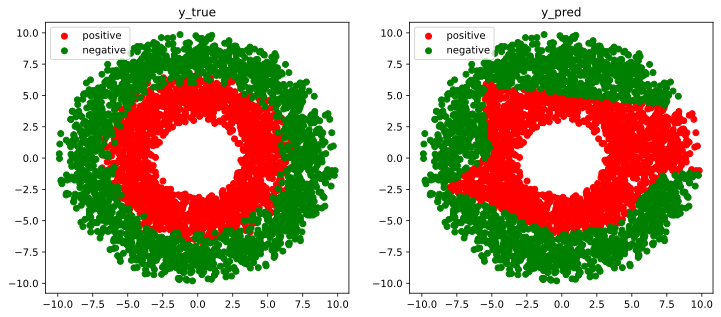

In [56]:
# Visualizing the results
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");